In [1]:
import numpy as np
import glob
from scipy.optimize import curve_fit
import h5py
from natsort import natsorted,realsorted
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

In [2]:
!pwd

/gpfs/gibbs/project/david_moore/ab2935/purity-monitor/Jupyter/Log


In [3]:
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
f_1='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/'
f_2='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/'
f_3='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/'
f_4='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/'
f_5='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/'
f_6='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/'
f_7='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/'
f_8='/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/'

In [5]:
def Voltages(Path):
    voltages = glob.glob(Path+'mca*')
    voltages = [x.split('_')[-2] for x in voltages]
    voltages = np.array(sorted([x.split('OV')[0] for x in voltages]))
    voltages = np.unique(voltages)
    voltages = voltages.astype(np.float)
    return(voltages)

In [6]:
def rebin(hx,h,bins):
    h_rebin=[]
    for i in range(int(len(h)/bins)):
        start_idx=i*bins
        end_idx=(i+1)*bins
        h_rebin.append(np.sum(h[start_idx:end_idx]))
    hx_rebin=range(len(h_rebin))
    return np.array(hx_rebin), np.array(h_rebin)

In [7]:
def gauss(x,a,mu,sigma):
    return (a*np.exp(-0.5*((x-mu)/sigma)**2))

In [8]:
def line(x,a,b):
    return a*(x-b)

In [9]:
def gain_calculator(PATH,N_BINS,N_PEAKS,PEAK_DISTANCE,PSL,PSR):

    BINS=N_BINS # Number of bins to rebin the MCA data with
    N_peaks= N_PEAKS# Number of peaks to use for calculating the gain
    gain_list=[] # empty list to fill in the values of gain, returned at the end of this function
    gain_err=[] # empty list to fill in the values of gain fit error, returned at the end of this function
    calib_pe=[]# empty list to fill in the values for calibrated PE 
    calib_count=[]
    Files = natsorted(glob.glob(PATH+'*mca*.h5'))
    # for loop to loop over all the files
    # some source data does not have clear enough peaks at the first OV, so we ignore that here
    for i,file in enumerate(Files):
        print(file) 
    
    
        f = h5py.File(file, 'r')  
        ch2 = f.get('ch2')
        for key in ch2.keys(): 
            df = np.array(ch2.get(key))
        h = df[250:]
        hx = np.arange(0,len(h),1)
        hx,h = rebin(hx,h, BINS)
        

        gain_temp=[]#reset the gain temp list here to store gain values for one file
        #Use scipy find_peaks to find peaks starting with a very high prominence 
        PROMINENCE=1E3 #This prominence is re-set here to ensure that every file starts out with a high prominence
    
        peaks,pdict=find_peaks(h,prominence=PROMINENCE,distance=PEAK_DISTANCE)
        peak_length=len(peaks)
        # We want to ensure that using a high prominence gives us at least N_peaks peaks to fit a straight line to. If it doesn't we reduce prominence till we get at least 3 peaks. N_peaks is set above
        while (peak_length<N_peaks+1):
            PROMINENCE=PROMINENCE-1
            
            peaks,pdict=find_peaks(h,prominence=PROMINENCE,distance=PEAK_DISTANCE)
            peak_length=len(peaks)
    
        plt.figure(figsize=(10,3)) # Call the figure here
        plt.subplot(1,2,1) # This subplot will plot the position of the peaks and also the data
        plt.xlim(0,10000/BINS)
        # plt.ylim(0,50)
        plt.yscale('log')
        plt.plot(hx[peaks],h[peaks],'*') # plot the peak markers
        plt.plot(hx,h,lw=1) #plot the signal
        
        
            
        
        
        
        for i,peak in enumerate(peaks[PSL:PSR]): # here we ignore the first peak because it could be the pedestal
            new_first_pe_max=hx[peak] # x-value of the peak
            new_max_value=h[peak] # height of the peak
            new_x_idx_array=(h<0.5*new_max_value) & (hx>new_first_pe_max) # returns a boolean array where both conditions are true
            new_right_side_x= hx[np.where(new_x_idx_array)[0][0]] # finding the first time where x_idx_array is True
            new_sigma_guess=1.2*np.abs(new_first_pe_max-new_right_side_x) # We need this to fit the width of the Gaussian peaks


            new_cut = (hx < new_first_pe_max+new_sigma_guess) & (hx > new_first_pe_max-new_sigma_guess) # This cut helps to fix the width of the peak-fit
            popt_new,pcov_new=curve_fit(gauss,hx[new_cut],h[new_cut],p0=[new_max_value,new_first_pe_max,new_sigma_guess],maxfev=100000) # We use curve_fit to return the optimal parameters and the covariance matrix
            plt.plot(hx[new_cut],gauss(hx[new_cut],*popt_new),color='r',label='Fit',lw=3) # Here we plot the fit on all the peaks
            gain_temp.append(popt_new[1]*BINS) # Here we append the value of the peak fit mean 

        plt.subplot(1,2,2) #This subplot shows the straight line fit to the peak means to obtain the slope/gain
        popt_temp,pcov_temp=curve_fit(line,np.arange(0,len(peaks[PSL:PSR])),gain_temp,p0=[10,0],maxfev=10000) #Use the straight line fit here
        plt.plot(np.arange(0,len(peaks[PSL:PSR])),line(np.arange(0,len(peaks[PSL:PSR])),*popt_temp),color='k',label=(str(np.round(popt_temp[0],2)))+'$\pm$'+str(np.round(np.sqrt(np.diag(pcov_temp))[0],2))+' ADC/PE') # plot the straight line fit
        plt.scatter(np.arange(0,len(peaks[PSL:PSR])),gain_temp,color='r') # plot the values of the peak means
        plt.legend(loc=2)
        gain_list.append(popt_temp[0]) # append the gain values to obtain BV later
        gain_err.append(np.sqrt(np.diag(pcov_temp))[0]) # append the straight line error fit
        plt.show()

    return(np.array(gain_list),np.array(gain_err))

## 0.5 kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_30.00OV_0.h5


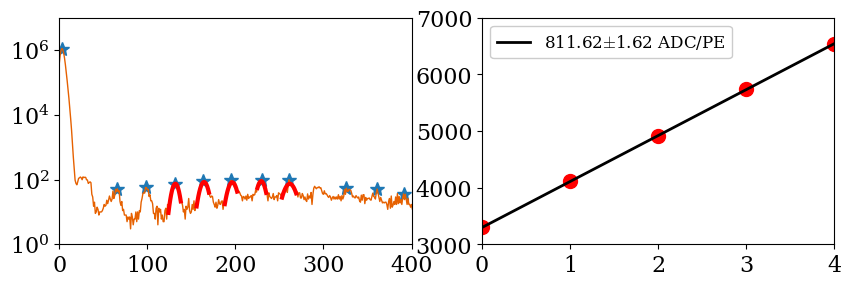

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_30.50OV_0.h5


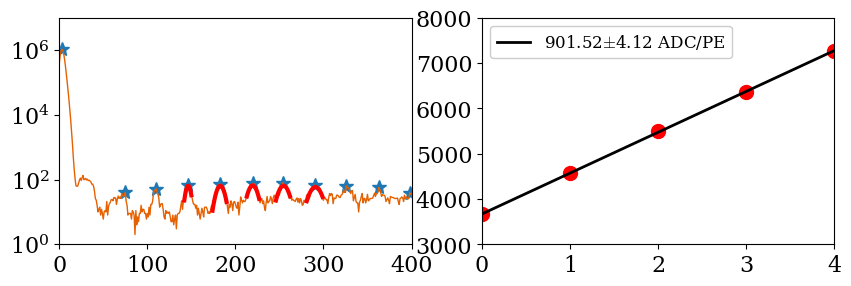

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_31.00OV_0.h5


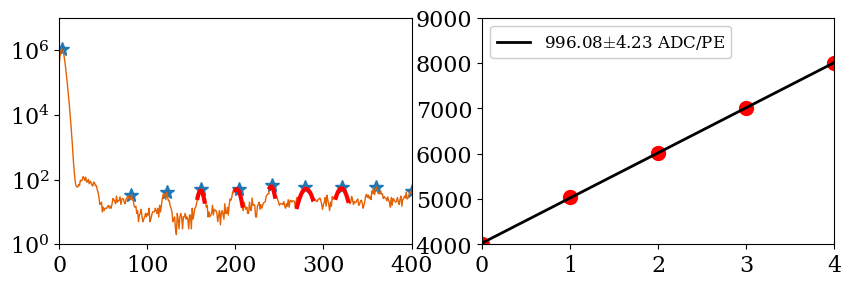

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_31.50OV_0.h5


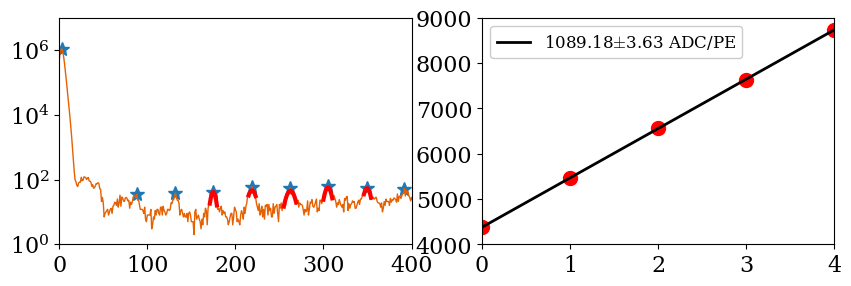

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_32.00OV_0.h5


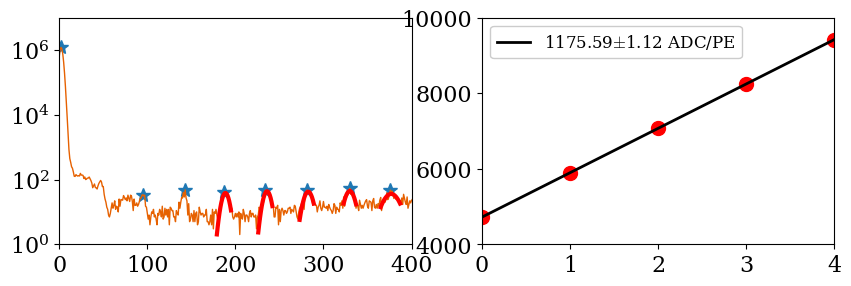

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_32.50OV_0.h5


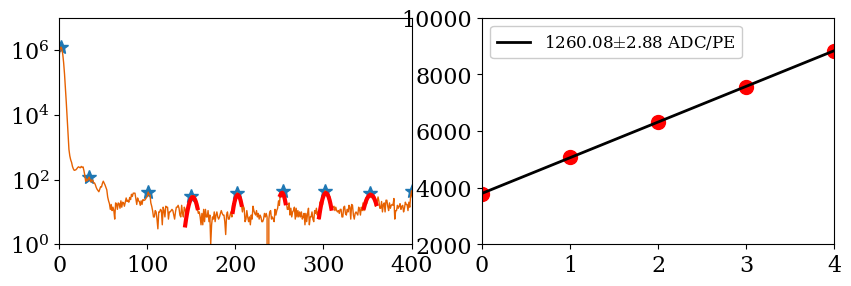

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_33.00OV_0.h5


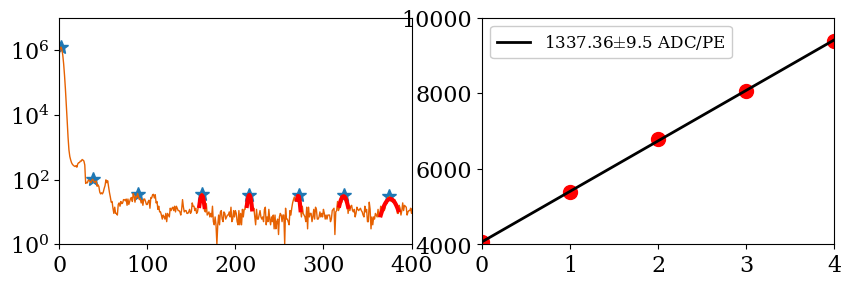

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_33.50OV_0.h5


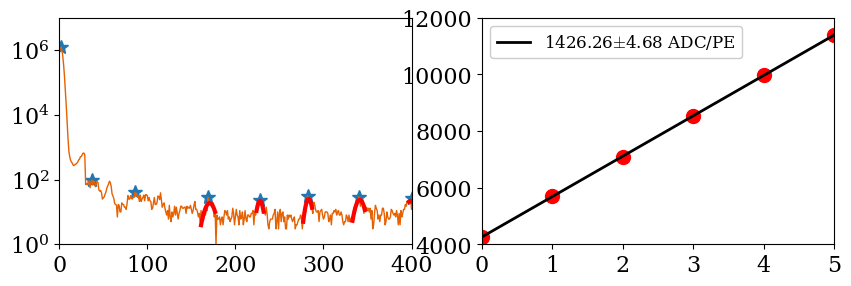

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.5kHz/mca_keith_34.00OV_0.h5


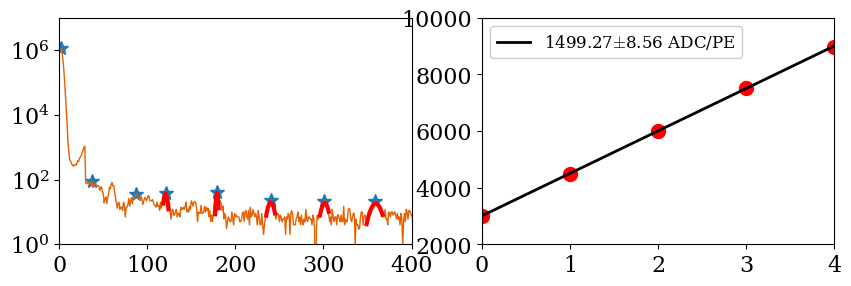

In [10]:
# gain_calculator(PATH,N_BINS,N_PEAKS,PEAK_DISTANCE,PSL,PSR):
f_1_gain_list,f_1_gain_err=gain_calculator(f_1,25,10,30,3,-3)
Voltages_f_1=Voltages(f_1)

## 0.6kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_30.00OV_0.h5


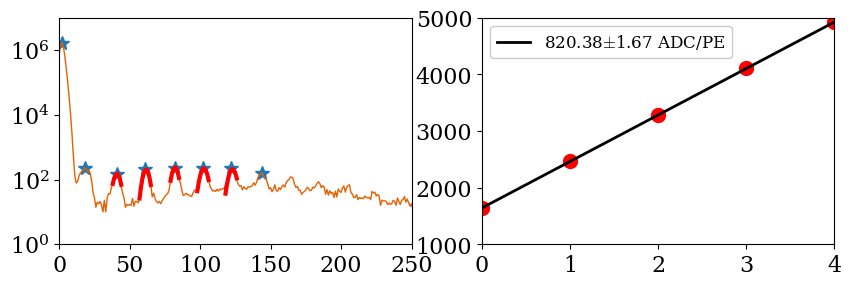

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_30.50OV_0.h5


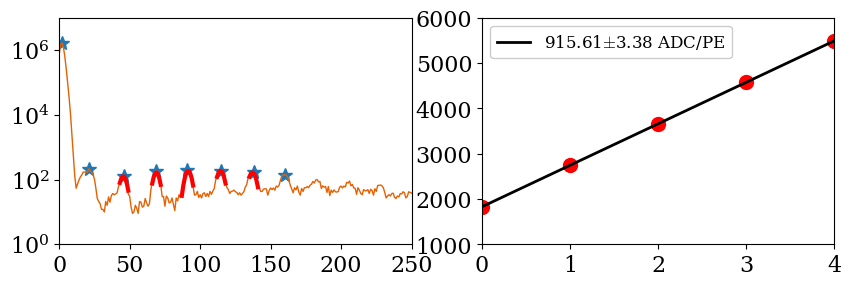

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_31.00OV_0.h5


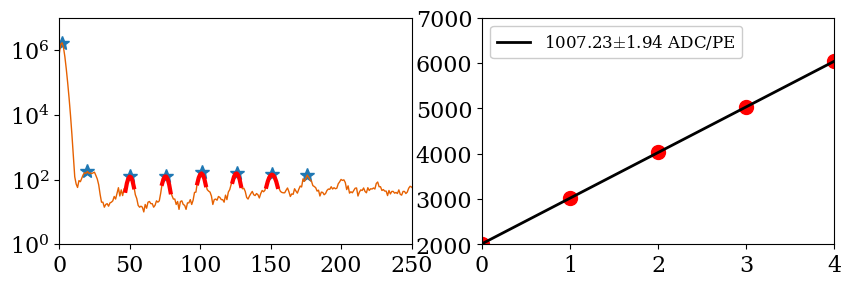

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_31.50OV_0.h5


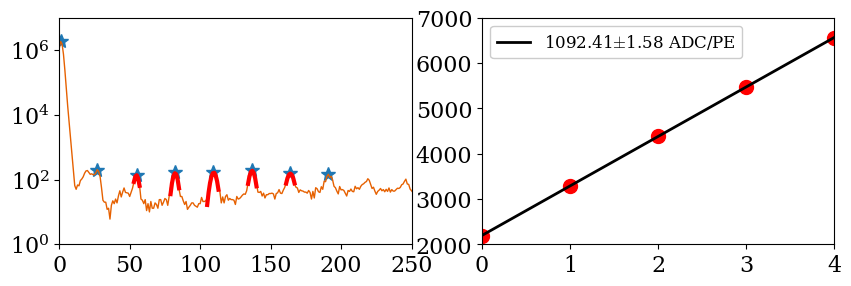

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_32.00OV_0.h5


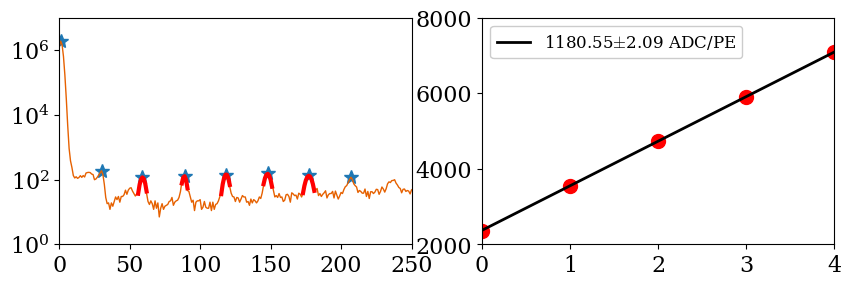

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_32.50OV_0.h5


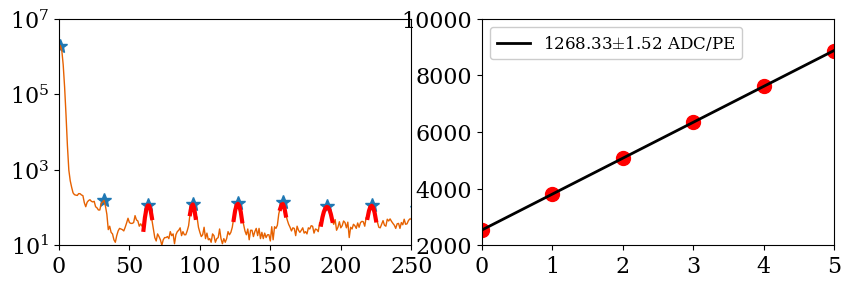

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_33.00OV_0.h5


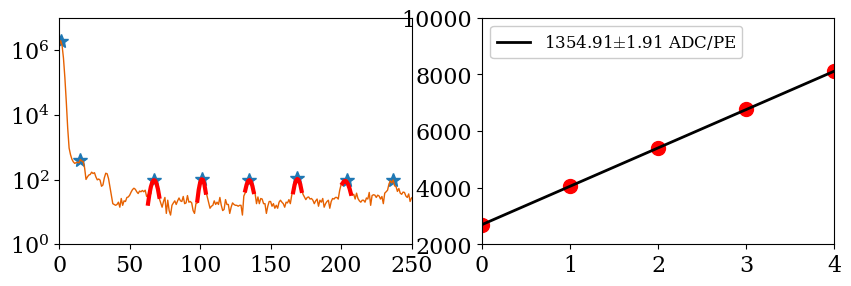

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_33.50OV_0.h5


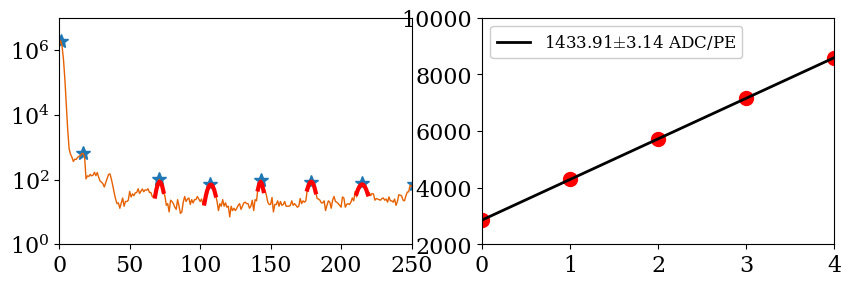

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.6kHz/mca_keith_34.00OV_0.h5


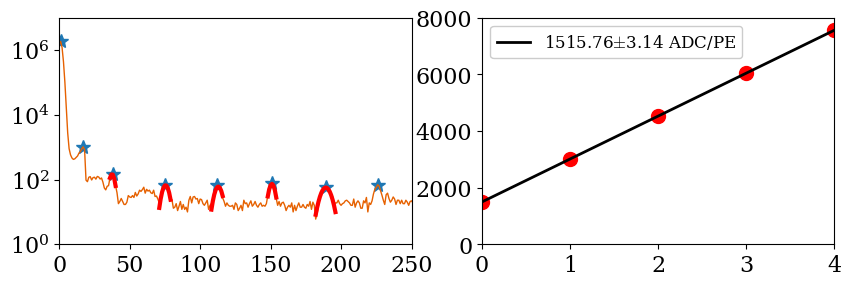

In [11]:
# gain_calculator(PATH,N_BINS,N_PEAKS,PEAK_DISTANCE,PSL,PSR):
f_2_gain_list,f_2_gain_err=gain_calculator(f_2,40,7,10,2,-1)
Voltages_f_2=Voltages(f_2)

## 0.7kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_30.00OV_0.h5


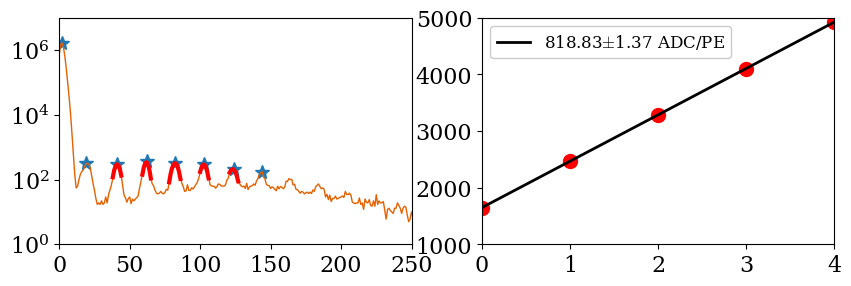

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_30.50OV_0.h5


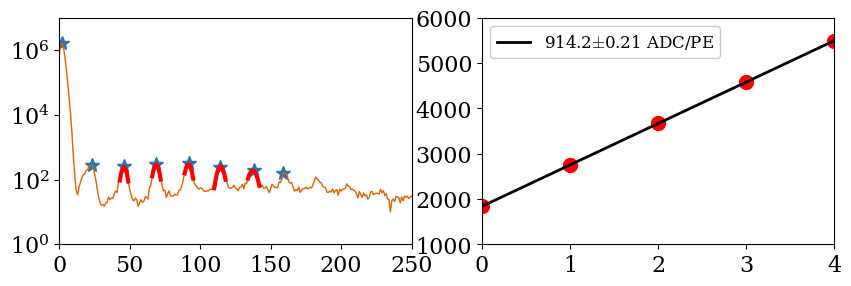

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_31.00OV_0.h5


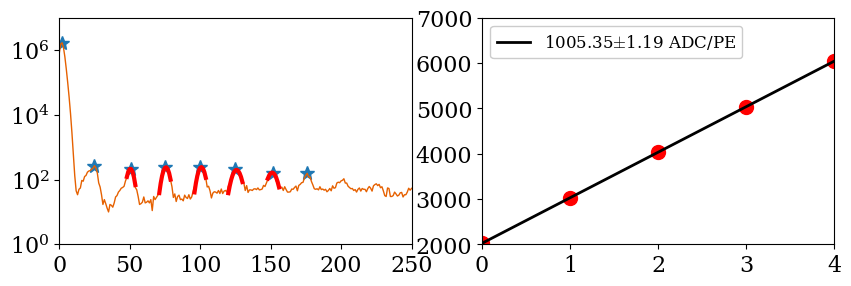

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_31.50OV_0.h5


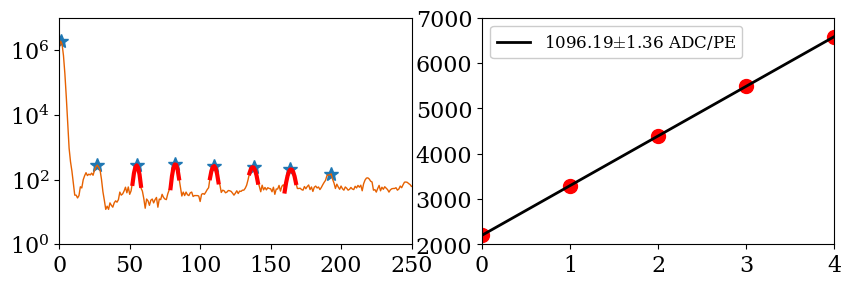

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_32.00OV_0.h5


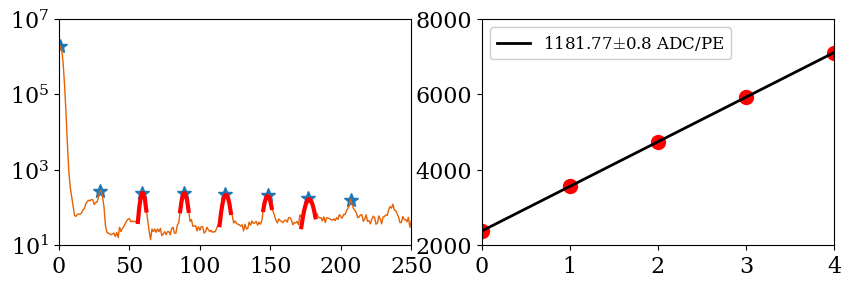

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_32.50OV_0.h5


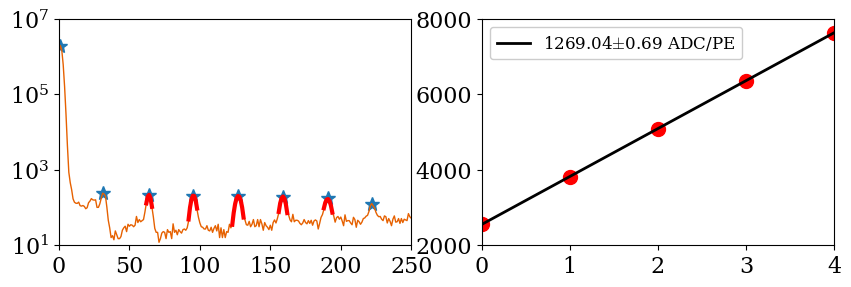

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_33.00OV_0.h5


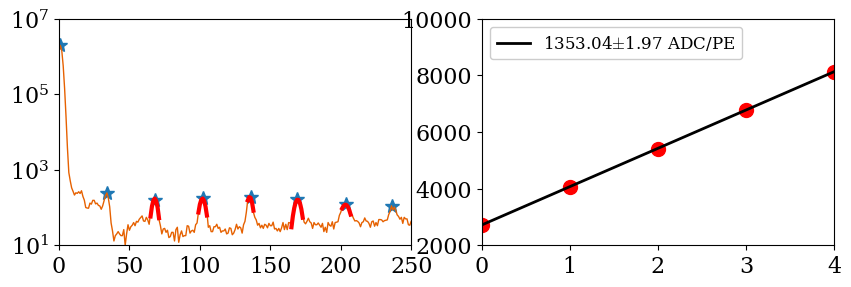

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_33.50OV_0.h5


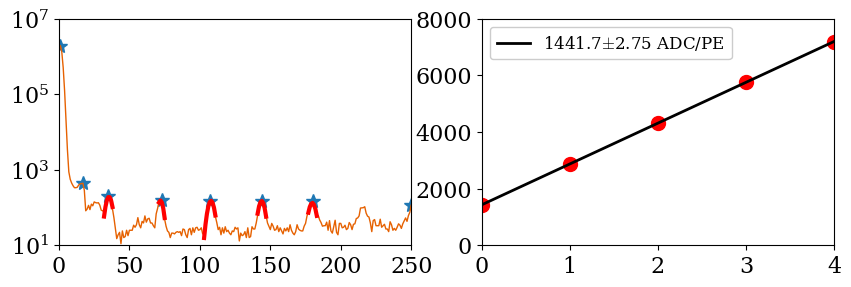

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.7kHz/mca_keith_34.00OV_0.h5


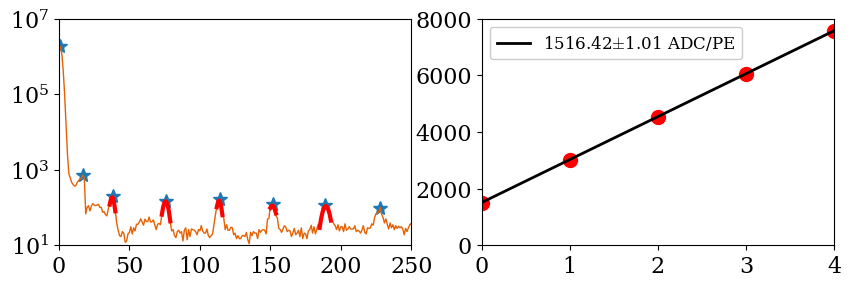

In [12]:
# gain_calculator(PATH,N_BINS,N_PEAKS,PEAK_DISTANCE,PSL,PSR):
f_3_gain_list,f_3_gain_err=gain_calculator(f_3,40,7,1,2,-1)
Voltages_f_3=Voltages(f_3)

## 0.8kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_30.00OV_0.h5


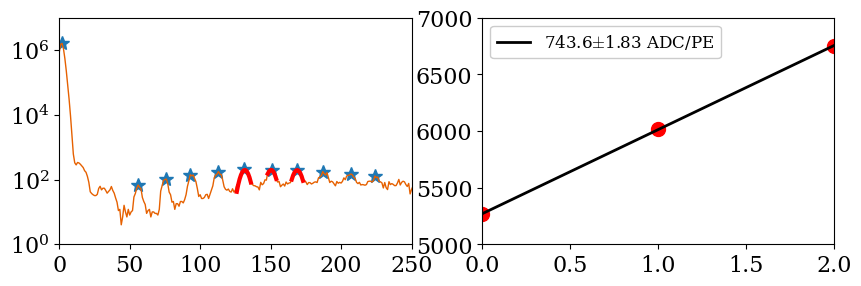

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_30.50OV_0.h5


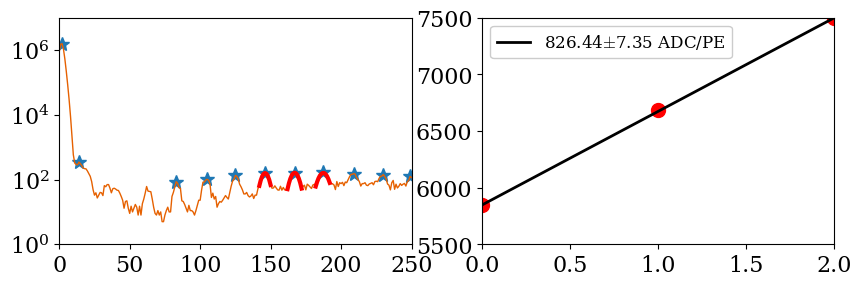

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_31.00OV_0.h5


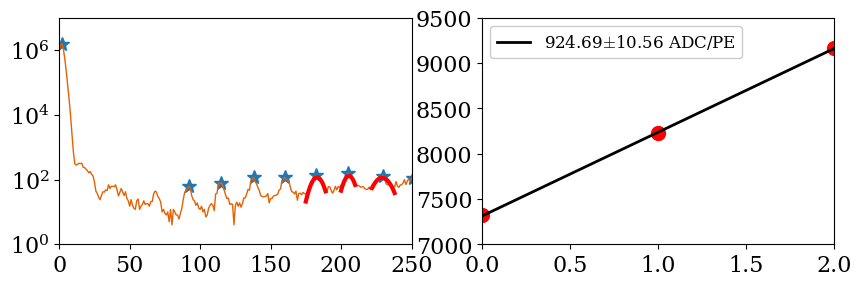

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_31.50OV_0.h5


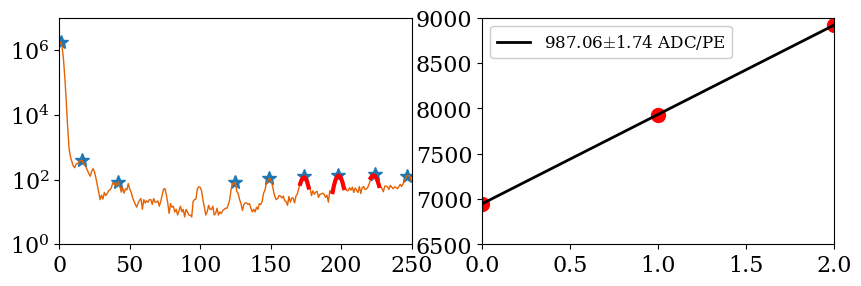

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_32.00OV_0.h5


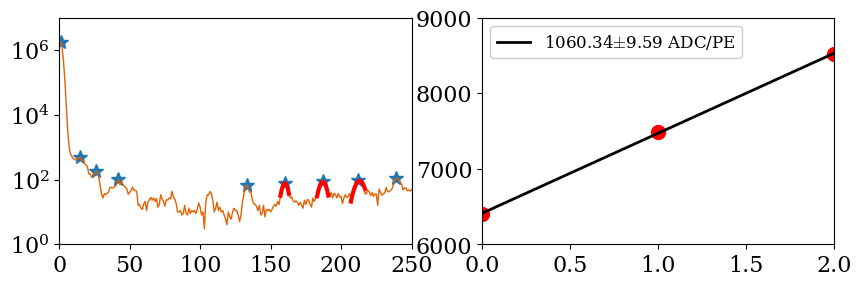

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_32.50OV_0.h5


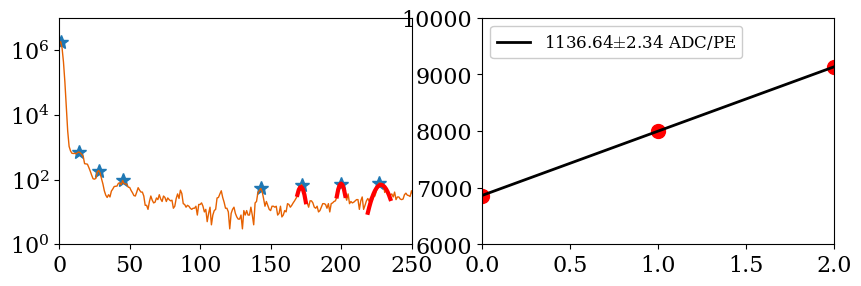

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_33.00OV_0.h5


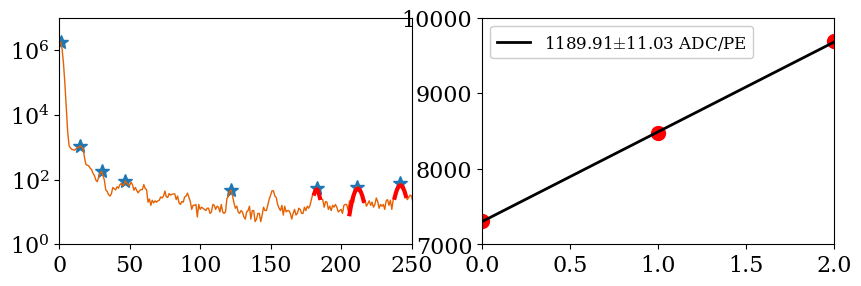

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_33.50OV_0.h5


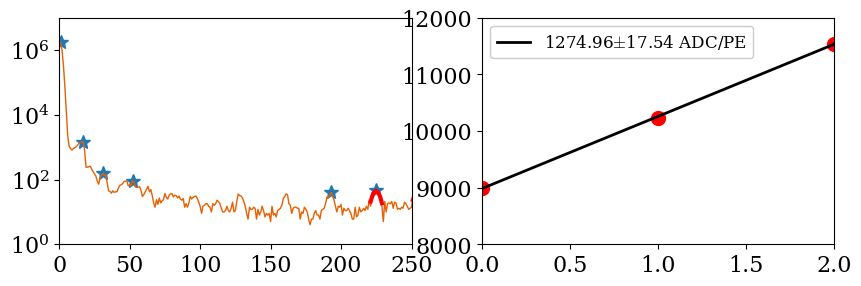

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.8kHz/mca_keith_34.00OV_0.h5


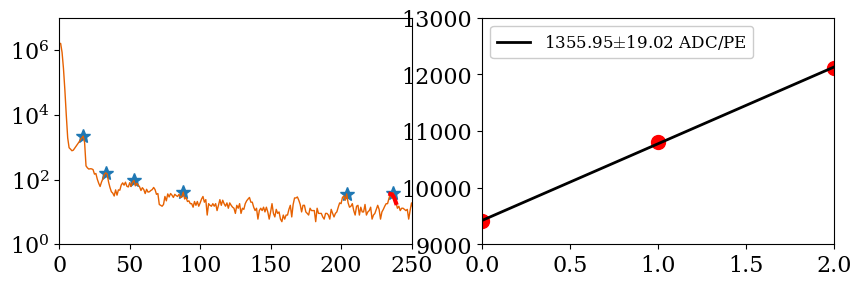

In [13]:
f_4_gain_list,f_4_gain_err=gain_calculator(f_4,40,10,10,5,-3)
Voltages_f_4=Voltages(f_4)

## 0.9kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_30.00OV_0.h5


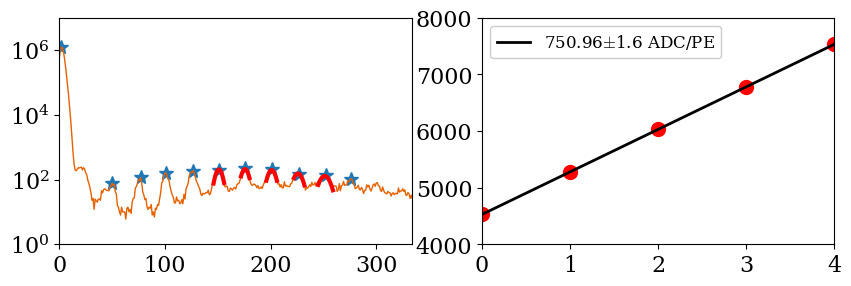

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_30.50OV_0.h5


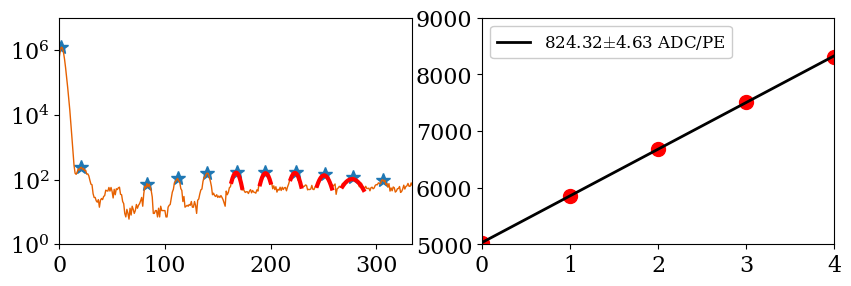

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_31.00OV_0.h5


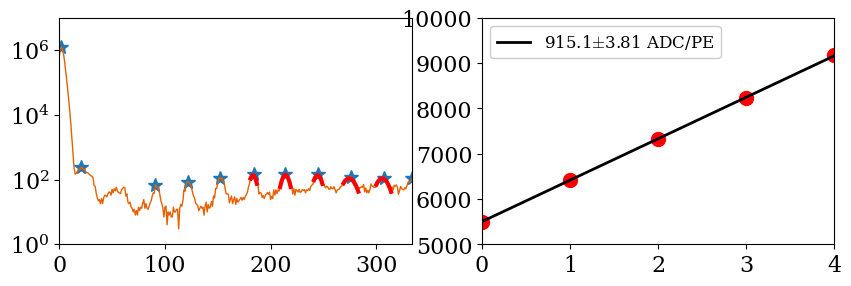

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_31.50OV_0.h5


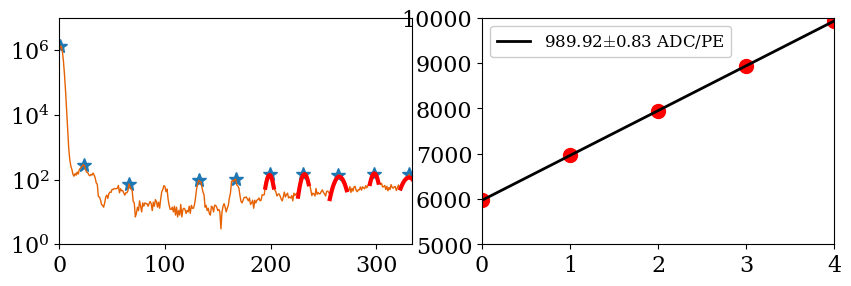

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_32.00OV_0.h5


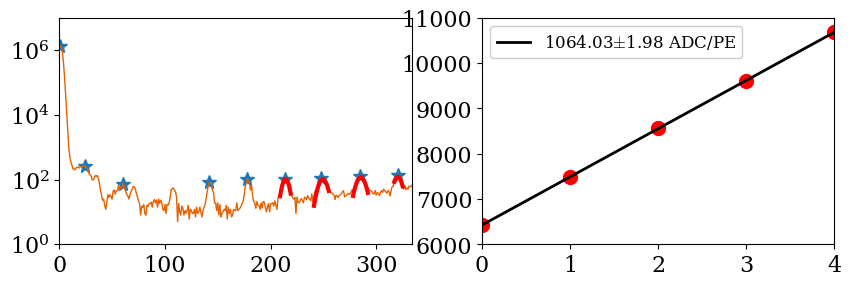

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_32.50OV_0.h5


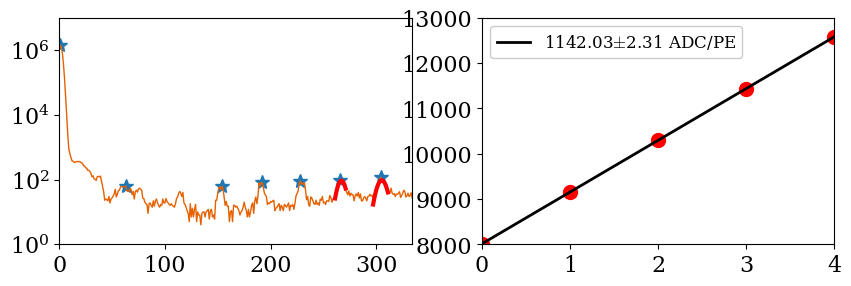

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_33.00OV_0.h5


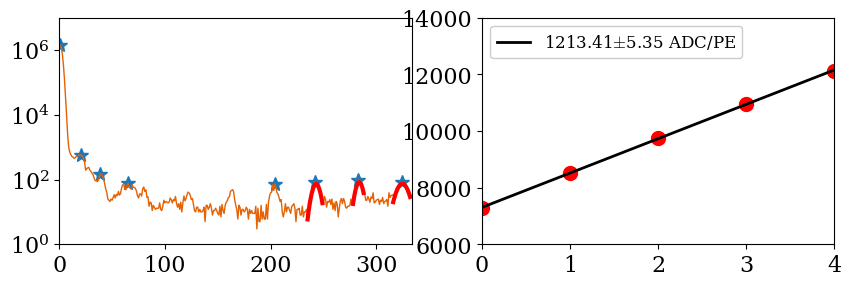

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_33.50OV_0.h5


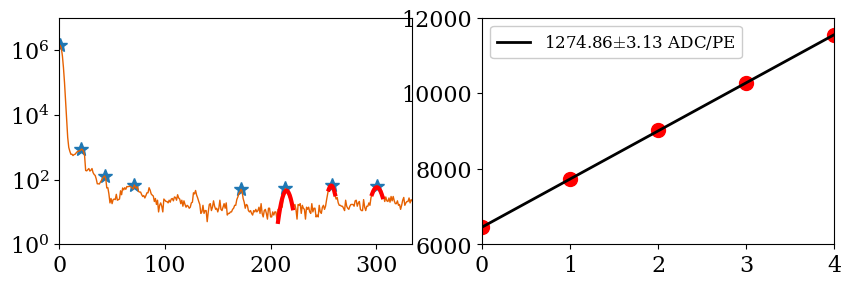

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/0.9kHz/mca_keith_34.00OV_0.h5


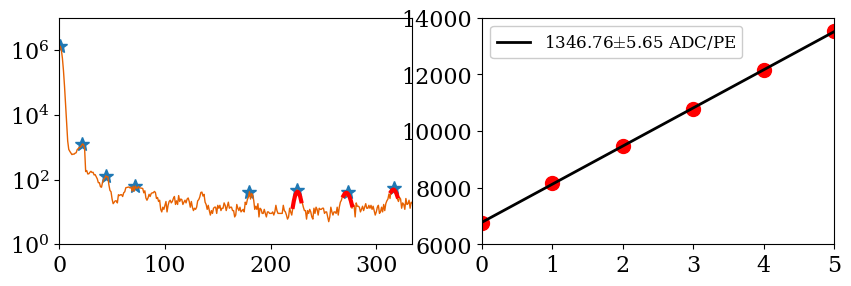

In [14]:
f_5_gain_list,f_5_gain_err=gain_calculator(f_5,30,10,10,5,-1)
Voltages_f_5=Voltages(f_5)

## 1.0kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_30.00OV_0.h5


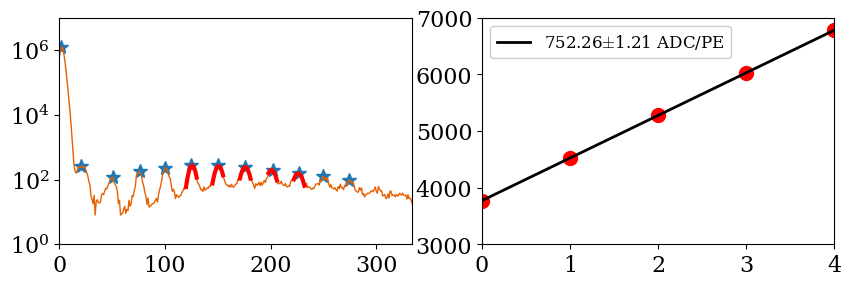

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_30.50OV_0.h5


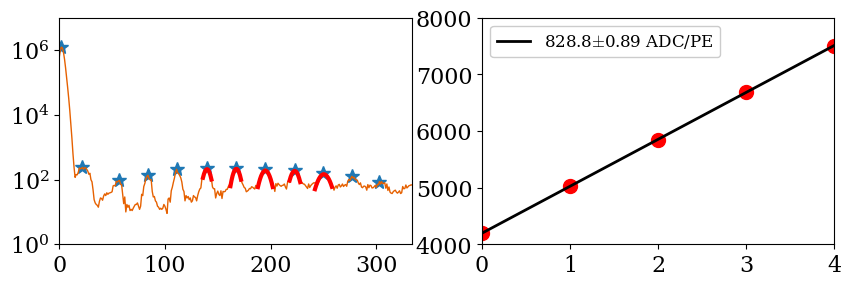

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_31.00OV_0.h5


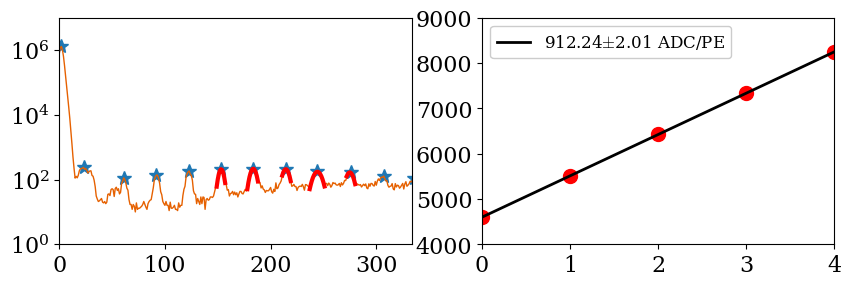

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_31.50OV_0.h5


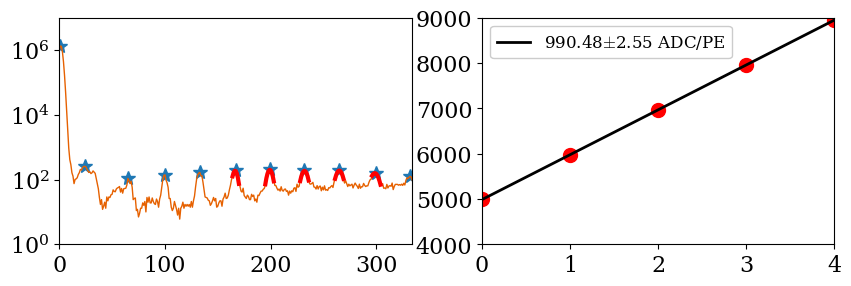

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_32.00OV_0.h5


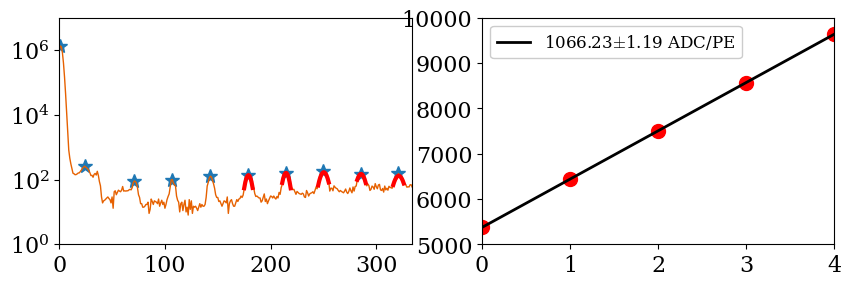

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_32.50OV_0.h5


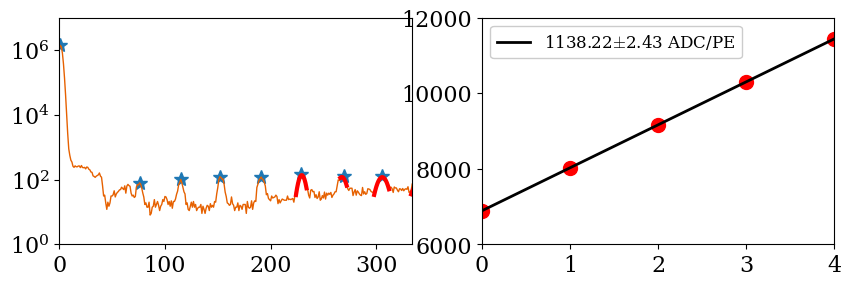

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_33.00OV_0.h5


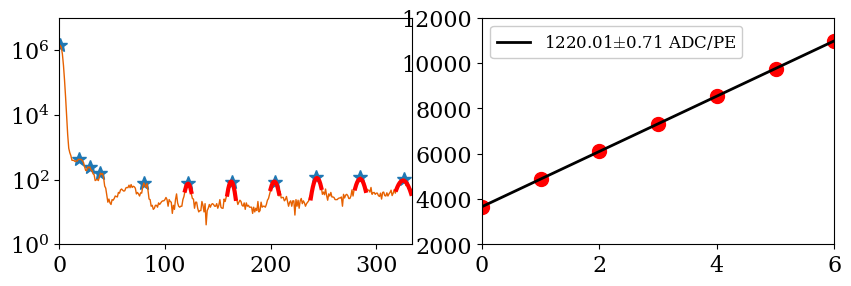

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_33.50OV_0.h5


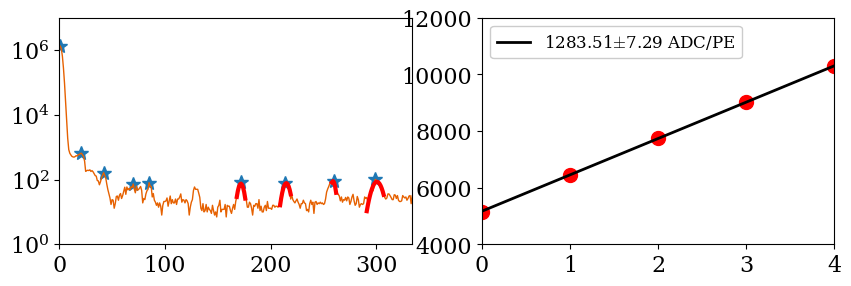

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/1.0kHz/mca_keith_34.00OV_0.h5


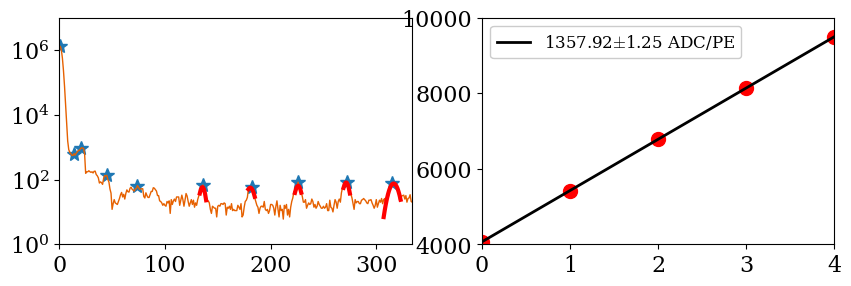

In [15]:
f_6_gain_list,f_6_gain_err=gain_calculator(f_6,30,11,5,5,-2)
Voltages_f_6=Voltages(f_6)

## 5kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_30.00OV_0.h5


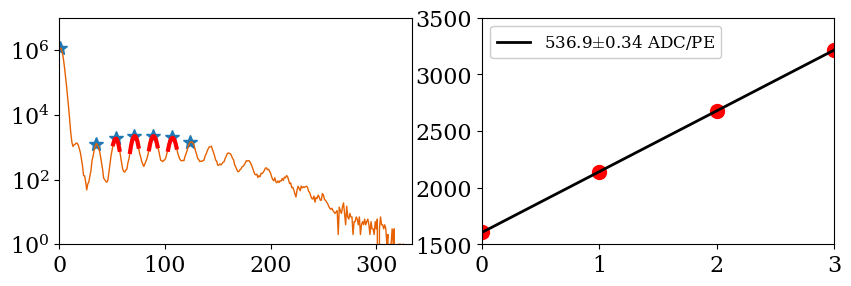

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_30.50OV_0.h5


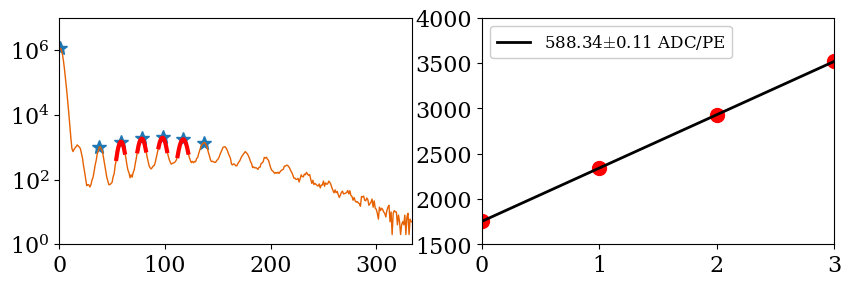

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_31.00OV_0.h5


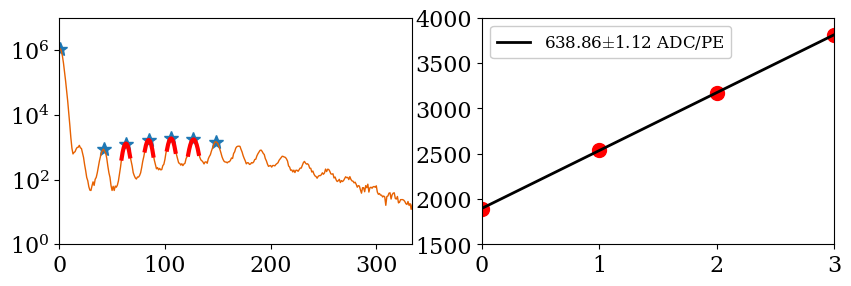

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_31.50OV_0.h5


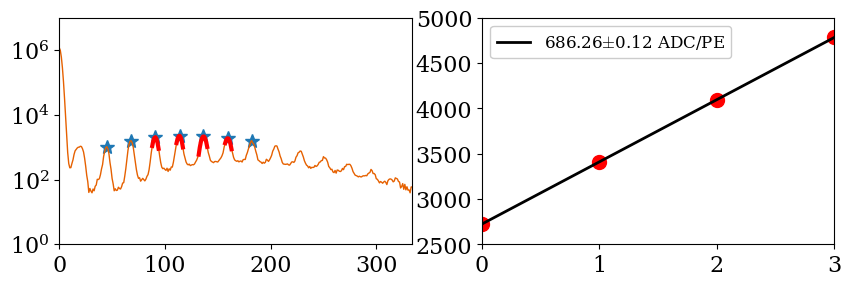

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_32.00OV_0.h5


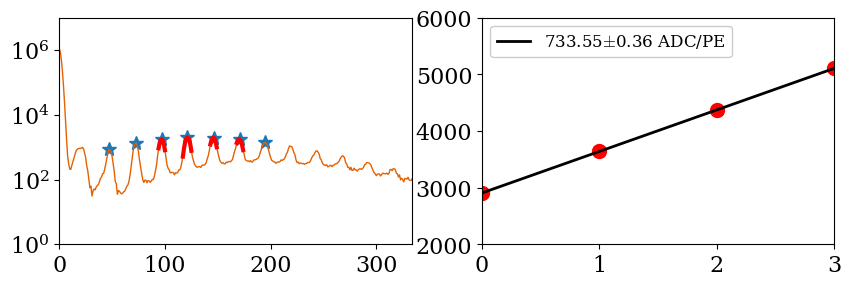

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_32.50OV_0.h5


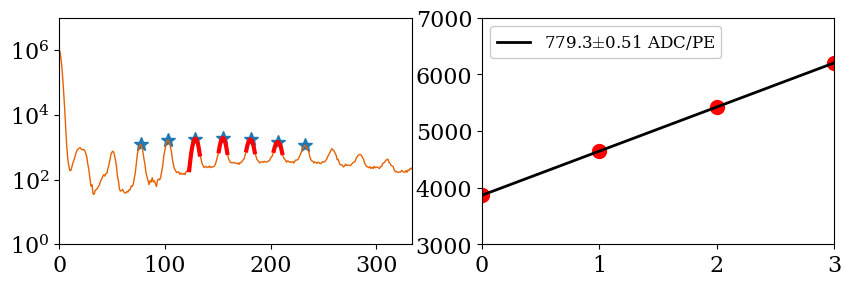

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_33.00OV_0.h5


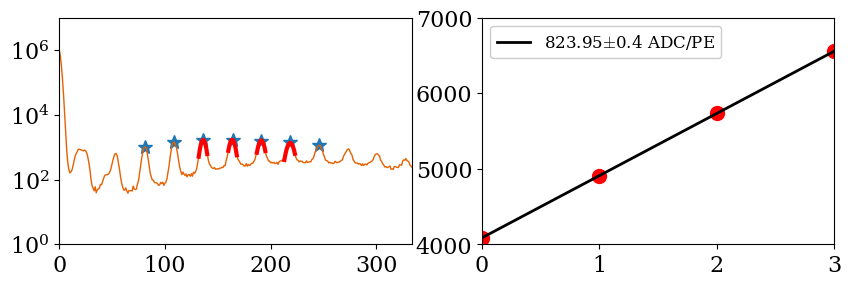

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_33.50OV_0.h5


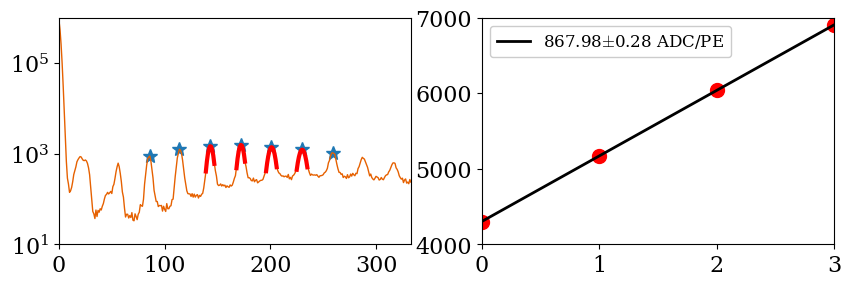

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/5.0kHz/mca_keith_34.00OV_0.h5


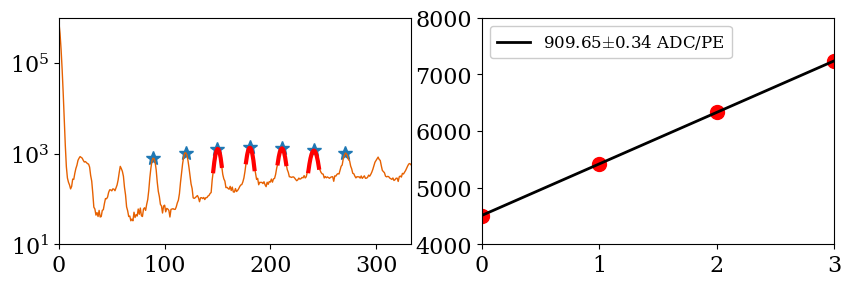

In [16]:
f_7_gain_list,f_7_gain_err=gain_calculator(f_7,30,6,1,2,-1)
Voltages_f_7=Voltages(f_7)

## 10kHz

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_30.00OV_0.h5


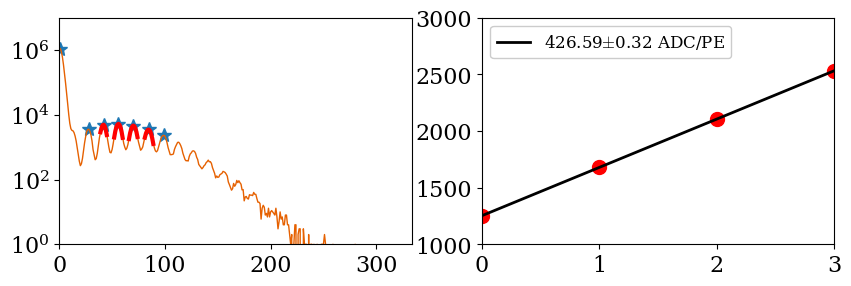

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_30.50OV_0.h5


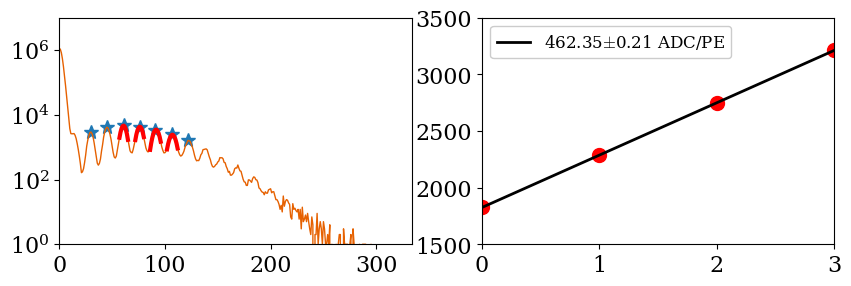

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_31.00OV_0.h5


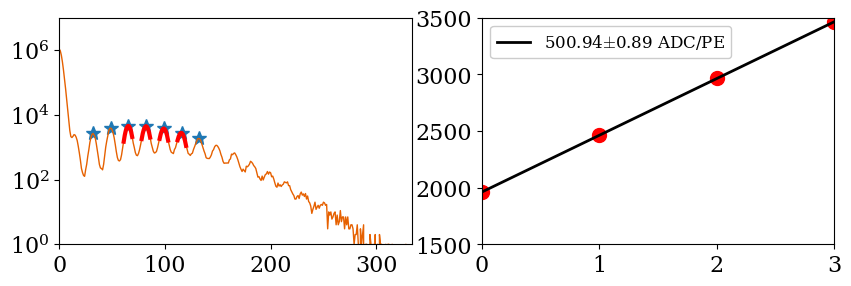

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_31.50OV_0.h5


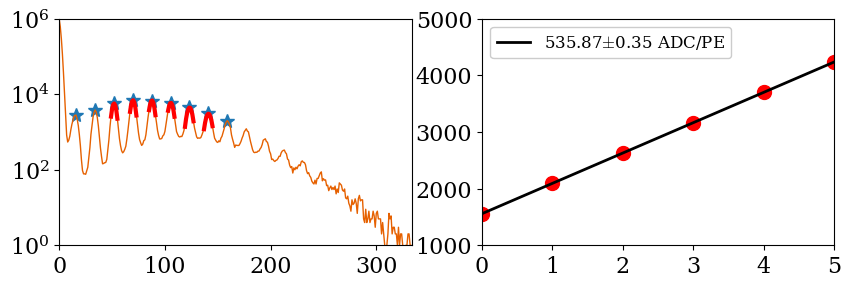

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_32.00OV_0.h5


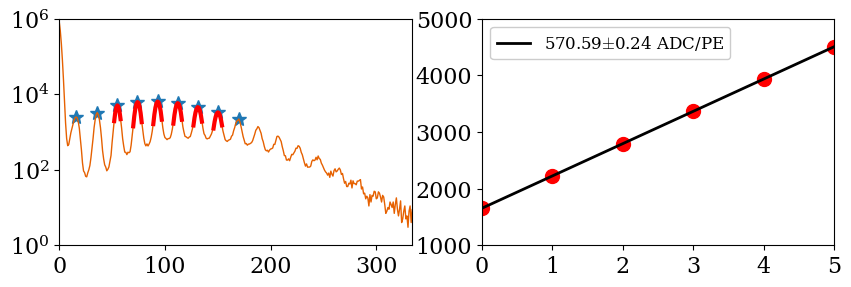

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_32.50OV_0.h5


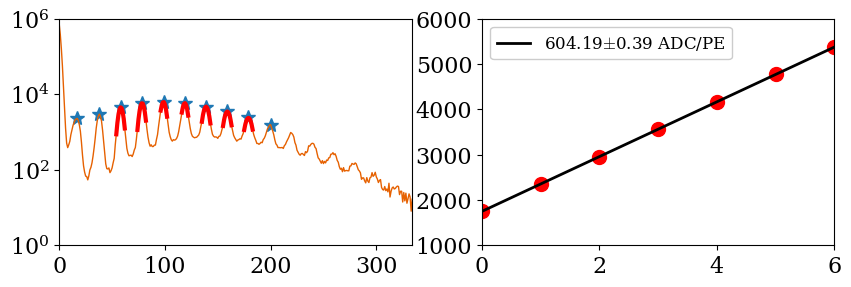

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_33.00OV_0.h5


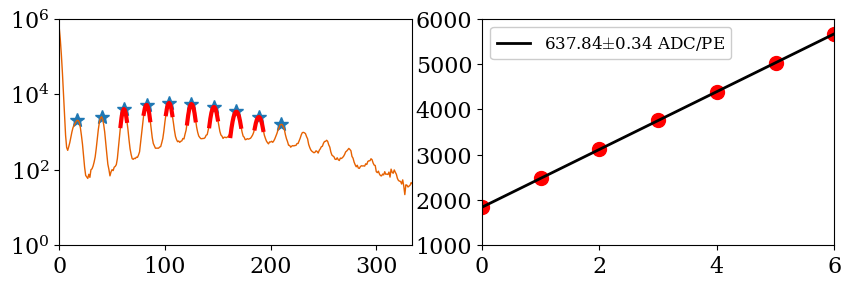

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_33.50OV_0.h5


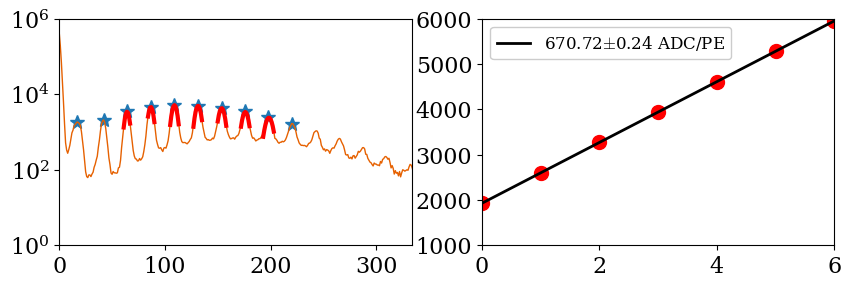

/gpfs/gibbs/project/david_moore/ab2935/Data/20220812/SRS_Gain_100/4Vpp_2min_0.5V_intervals/10.0kHz/mca_keith_34.00OV_0.h5


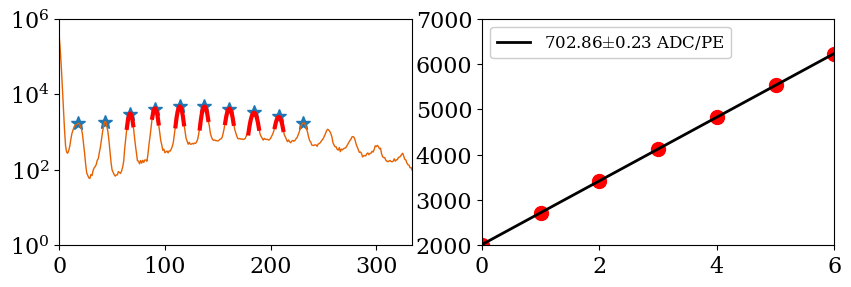

In [17]:
f_8_gain_list,f_8_gain_err=gain_calculator(f_8,30,6,1,2,-1)
Voltages_f_8=Voltages(f_8)

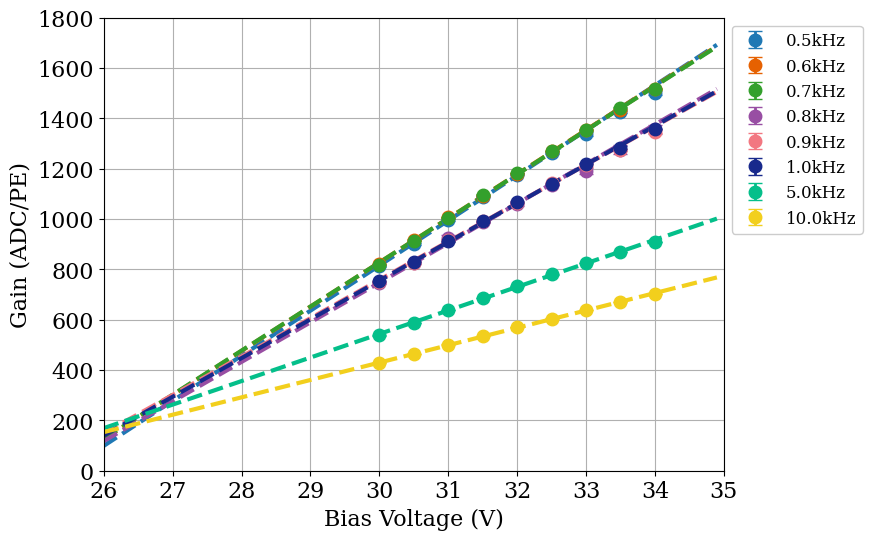

In [18]:
x_data=np.arange(26,35,0.1)
plt.figure(figsize=(8,6))

All_Voltages = [Voltages_f_1, Voltages_f_2, Voltages_f_3, Voltages_f_4, Voltages_f_5, Voltages_f_6, Voltages_f_7,\
     Voltages_f_8]
All_Gains = [f_1_gain_list, f_2_gain_list, f_3_gain_list, f_4_gain_list, f_5_gain_list, f_6_gain_list, f_7_gain_list,\
     f_8_gain_list]
All_Errors = [f_1_gain_err, f_2_gain_err, f_3_gain_err, f_4_gain_err, f_5_gain_err, f_6_gain_err, f_7_gain_err,\
     f_8_gain_err]
All_Frequencies = [0.5,0.6,0.7,0.8,0.9,1.0,5.0,10.0]
Colours_all=[colors[i] for i in range(len(All_Voltages))]

for voltages, gains, errors, frequencies, colours in zip(All_Voltages, All_Gains, All_Errors, All_Frequencies, Colours_all):
    plt.errorbar(voltages, gains, yerr=errors, fmt='o',label=str(frequencies)+'kHz', ms=9,color=colours)
    popt,pcov=curve_fit(line,voltages,gains,p0=[31,26],sigma=errors)
#     label = 'BV= '+str(np.round(popt[1],2))+ '$\pm$'+ str(np.round(np.sqrt(np.diag(pcov)[1]),2))+' V'
    plt.plot(x_data, line(x_data,*popt), ls='--',color=colours,lw=3)

plt.grid()
plt.ylabel('Gain (ADC/PE)')
plt.xlabel('Bias Voltage (V)')
plt.legend(bbox_to_anchor =(1, 1))
# plt.legend(loc='best')
# plt.ylim(0,200)
plt.xlim(26,35)
plt.savefig('Gain_vs_frequency.pdf')
plt.show()